In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
from sklearn.feature_extraction import DictVectorizer

In [3]:
pd.__version__

'1.4.2'

In [4]:
jan_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
feb_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

# Q1: Downloading data

In [5]:
print(f"Shape of \n Jan'23: {jan_df.shape} \n Feb'23: {feb_df.shape}")

Shape of 
 Jan'23: (3066766, 19) 
 Feb'23: (2913955, 19)


# Q2: Duration of trip

In [6]:
jan_df['duration'] = jan_df['tpep_dropoff_datetime'] - jan_df['tpep_pickup_datetime']
jan_df['duration'] = jan_df['duration']/pd.Timedelta(minutes=1)
jan_df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.0,0.0,1.0,34.9,2.5,0.0,12.750000


In [7]:
print(f"Standard deviation of trips duration in January: \n {jan_df['duration'].std()}")

Standard deviation of trips duration in January: 
 42.594351241920904


# Dropping outliers

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


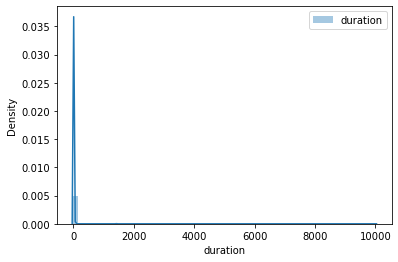

In [8]:
sns.distplot(jan_df['duration'], label='duration')
plt.legend()

In [9]:
rows_within_bounds = jan_df[(jan_df['duration']>=1) & (jan_df['duration']<=60)].shape[0]
print(f"Fraction of records left after outlier removal: {100*rows_within_bounds/jan_df.shape[0]}%")

Fraction of records left after outlier removal: 98.1220282212598%


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


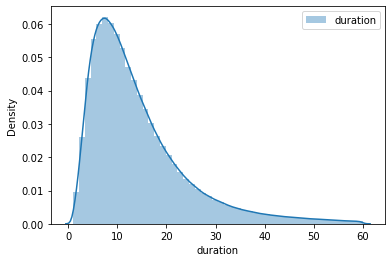

In [10]:
jan_df = jan_df[(jan_df['duration']>=1) & (jan_df['duration']<=60)]
sns.distplot(jan_df['duration'], label='duration')
plt.legend()

# One hot encoding

In [11]:
cat_columns = ['PULocationID', 'DOLocationID']

In [12]:
jan_df[cat_columns] = jan_df[cat_columns].astype(str)

In [13]:
cat_col_dicts = jan_df[cat_columns].to_dict(orient='records')
cat_col_dicts

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'},
 {'PULocationID': '234', 'DOLocationID': '68'},
 {'PULocationID': '79', 'DOLocationID': '264'},
 {'PULocationID': '164', 'DOLocationID': '143'},
 {'PULocationID': '138', 'DOLocationID': '33'},
 {'PULocationID': '33', 'DOLocationID': '61'},
 {'PULocationID': '79', 'DOLocationID': '186'},
 {'PULocationID': '90', 'DOLocationID': '48'},
 {'PULocationID': '113', 'DOLocationID': '255'},
 {'PULocationID': '237', 'DOLocationID': '239'},
 {'PULocationID': '143', 'DOLocationID': '229'},
 {'PULocationID': '137', 'DOLocat

In [14]:
cat_cols_vectorizer = DictVectorizer()
X_train = cat_cols_vectorizer.fit_transform(cat_col_dicts)
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


# Train model

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
y_train = jan_df['duration'].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_train)

In [21]:
print(f"Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}")

Train RMSE: 7.6492610279057605


# Eval model

In [22]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [23]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [24]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [26]:
X_val = cat_cols_vectorizer.transform(val_dicts) 
y_val = df_val.duration.values

In [27]:
y_pred = lr.predict(X_val)

In [28]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 7.81183265470218
